# MNIST classification classical model (Pytorch)

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import pennylane as qml
from pennylane import numpy as np
import torch # to use PennyLane TorchLayer class to perform circuit operations and optimisations with PyTorch backend
from matplotlib import pyplot as plt

from utils.tools import get_dataset, visualise_data

2025-04-17 12:02:49.114828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744855369.130792   24469 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744855369.135729   24469 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744855369.148296   24469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744855369.148307   24469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744855369.148309   24469 computation_placer.cc:177] computation placer alr

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
n_px = 8

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_px):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_px*n_px, 8),
            nn.ReLU(),
            nn.Linear(8, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
model = NeuralNetwork(n_px).to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=10, bias=True)
    (3): Softmax(dim=None)
  )
)


In [7]:
model = CNN(n_px).to(device)
print(model)

TypeError: Linear.__init__() missing 2 required positional arguments: 'in_features' and 'out_features'

### CNN model

In [8]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [5]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        """
        Define the layers of the convolutional neural network.

        Parameters:
            in_channels: int
                The number of channels in the input image. For MNIST, this is 1 (grayscale images).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


I0000 00:00:1744855370.871236   24469 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10747 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:02:00.0, compute capability: 6.0


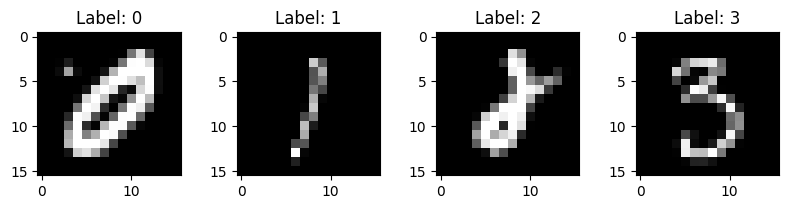

In [3]:
digits = [0,1,2,3]
n_px = 16

(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

# show one image from each class
x_vis = [(x_train[y_train==digit])[np.random.choice(range(10))] for digit in digits] 
y_vis = range(len(digits))

visualise_data(digits, x_vis, y_vis)

In [4]:
input_size = n_px * n_px  # 28x28 pixels (not directly used in CNN)
num_classes = len(digits)  # digits 0-9
learning_rate = 0.001
batch_size = 32
num_epochs = 10  # Reduced for demonstration purposes

In [8]:
train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        # Move data and targets to the device (GPU/CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass: compute the model output
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass: compute the gradients
        optimizer.zero_grad()
        loss.backward()

        # Optimization step: update the model parameters
        optimizer.step()


Epoch [1/10]


100%|█████████████████████████████████████████| 938/938 [00:10<00:00, 88.43it/s]


Epoch [2/10]


100%|████████████████████████████████████████| 938/938 [00:07<00:00, 119.64it/s]


Epoch [3/10]


100%|████████████████████████████████████████| 938/938 [00:07<00:00, 123.78it/s]


Epoch [4/10]


100%|████████████████████████████████████████| 938/938 [00:07<00:00, 122.99it/s]


Epoch [5/10]


100%|████████████████████████████████████████| 938/938 [00:08<00:00, 115.83it/s]


Epoch [6/10]


100%|████████████████████████████████████████| 938/938 [00:08<00:00, 113.00it/s]


Epoch [7/10]


100%|████████████████████████████████████████| 938/938 [00:08<00:00, 115.37it/s]


Epoch [8/10]


100%|████████████████████████████████████████| 938/938 [00:08<00:00, 112.73it/s]


Epoch [9/10]


100%|████████████████████████████████████████| 938/938 [00:08<00:00, 115.03it/s]


Epoch [10/10]


100%|████████████████████████████████████████| 938/938 [00:07<00:00, 123.71it/s]


In [12]:
def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on the given dataset loader.

    Parameters:
        loader: DataLoader
            The DataLoader for the dataset to check accuracy on.
        model: nn.Module
            The neural network model.
    """
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass: compute the model output
            scores = model(x)
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            num_correct += (predictions == y).sum()  # Count correct predictions
            num_samples += predictions.size(0)  # Count total samples

        # Calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
    
    model.train()  # Set the model back to training mode

# Final accuracy check on training and test sets
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Checking accuracy on training data
Got 59488/60000 with accuracy 99.15%
Checking accuracy on test data
Got 9869/10000 with accuracy 98.69%


### PGD attack

In [13]:
# simple implementation of projected gradient descent (PGD) attack (without randomized starting points — cf. BIM)
# for an introduction to PGD, see https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent
def PGD(model, feats, labels, epsilon=0.1, alpha=0.1, num_iter=10):

    # initialize image perturbations with zero
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]

        # forward & backward pass through the model, accumulating gradients
        l = loss(torch.stack(outputs), labels)
        l.backward()

        # use gradients with respect to inputs and clip the results to lie within the epsilon boundary
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
perturbations = PGD(model=model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.2) # even smaller values of epsilon do some damage (epsilon > 0.04)
perturbed_x = x_vis_torch + perturbations

# check model performance
adversarial_preds = [model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

# visualise_data(digits, perturbed_x.reshape(-1, n_px, n_px), y_vis, adversarial_class_output)

## Tutorial on adversarial robustness